# Visualiztaion & Interpretation of Surrogate Model
Objectives:
- Examine spatial and temporal behavior of predicted reservoir pressure using the surrogate model.
- Explore feature–target relationships to understand how geological and operational variables influence pressure dynamics.
- Assess predictive accuracy by comparing surrogate outputs against ground-truth simulation data.
- Produce 2D spatial visualizations, temporal evolution plots, and feature-based interpretations relevant to reservoir performance.
- Derive engineering insights for CCS performance, such as pressure containment efficiency, injection effects, and overall storage stability.


**Source:** Society of Petroleum Engineers (SPE)  
**Dataset:** SPE Comparative Solution Project - Model 11C (3D CO₂ Injection)

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

import joblib
from tensorflow import keras
import shap

sns.set(style="whitegrid")

In [2]:
# Paths
PROCESSED = Path(r"C:\Users\tetec\Documents\Data Project Coding\.vscode\Project data\spe11c\data\processed")
MODELS = Path(r"C:\Users\tetec\Documents\Data Project Coding\.vscode\Project data\spe11c\models")

# Load arrays
X = np.load(PROCESSED / "X.npy")
y = np.load(PROCESSED / "y.npy")

X_train_scaled = np.load(PROCESSED / "X_train_scaled.npy")
X_test_scaled  = np.load(PROCESSED / "X_test_scaled.npy")

y_train = np.load(PROCESSED / "y_train.npy")
y_test  = np.load(PROCESSED / "y_test.npy")

# Load scaler for inverse-transform
y_scaler = joblib.load(MODELS / "y_scaler.pkl")

# Load surrogate model
mlp = keras.models.load_model(MODELS / "Surrogate_MLP.keras")

print("Data and model loaded successfully.")


Data and model loaded successfully.


In [3]:
# Surrogate predictions
y_pred_scaled = mlp.predict(X_test_scaled).flatten()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

print("Predictions generated.")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Predictions generated.


### 1. Model Accuracy Metrics

In [4]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Surrogate MLP — MSE: {mse:.4f}")
print(f"Surrogate MLP — R²: {r2:.4f}")

Surrogate MLP — MSE: 1364424320.0000
Surrogate MLP — R²: 0.9999


#### 1.1 Scatter Plot: True vs Predicted

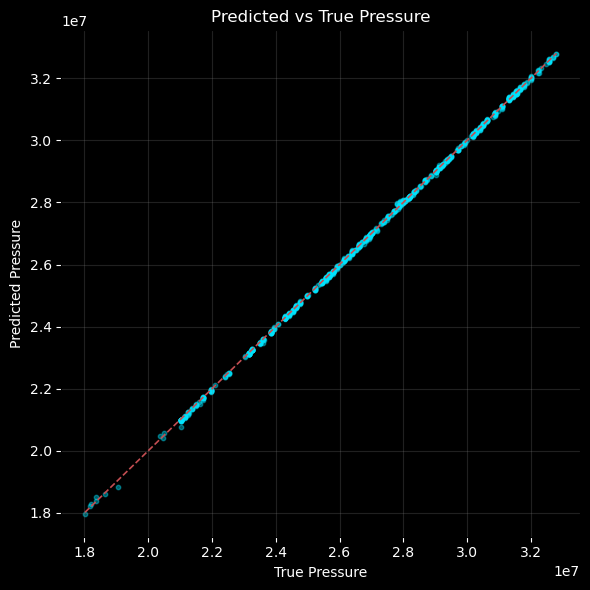

In [8]:
plt.style.use("default")

fig, ax = plt.subplots(figsize=(6, 6))

# --- Set black backgrounds ---
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# --- Plot data ---
ax.scatter(y_test, y_pred, alpha=0.4, s=10, color="#00E5FF")  # bright cyan
ax.plot(
    [y_test.min(), y_test.max()], 
    [y_test.min(), y_test.max()],
    'r--', linewidth=1.2
)

# --- Labels and title (white text) ---
ax.set_xlabel("True Pressure", color="white")
ax.set_ylabel("Predicted Pressure", color="white")
ax.set_title("Predicted vs True Pressure", color="white")

# --- Tick color ---
ax.tick_params(colors="white")

# --- Grid (dim gray to be visible but not overpowering) ---
ax.grid(True, color="gray", alpha=0.25)

plt.tight_layout()
plt.show()


The scatter plot compares true reservoir pressure from the full-physics simulator (SPE 11C dataset) against predicted pressure generated by the trained surrogate model (MLP). The points fall very closely along the 1:1 reference line (red dashed), indicating that the surrogate successfully reproduces the pressure behavior of the numerical simulator.

#### 1.2 Error Histogram

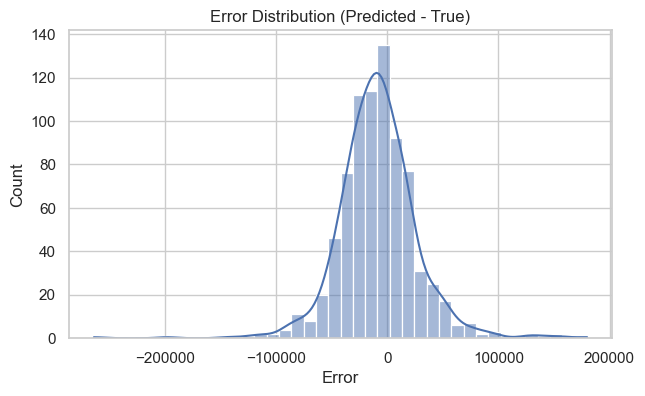

In [20]:
errors = y_pred - y_test

plt.figure(figsize=(7,4))
sns.histplot(errors, bins=40, kde=True)
plt.title("Error Distribution (Predicted - True)")
plt.xlabel("Error")
plt.show()

The predicted pressures align closely with the true simulation results, indicating that the surrogate model accurately captures the reservoir pressure behavior. The histogram shows that most errors are centered near zero and follow a symmetric, Gaussian-like distribution. This means the model has no systematic bias (neither consistently over-predicting nor under-predicting) and the remaining deviations behave like small random noise.

For CCS applications, this accuracy suggests the surrogate reliably reproduces pressure buildup patterns, making it suitable for screening injection scenarios, evaluating reservoir response, and supporting fast decision-making compared to full numerical simulations.

### 2. Temporal Behavior Analysis

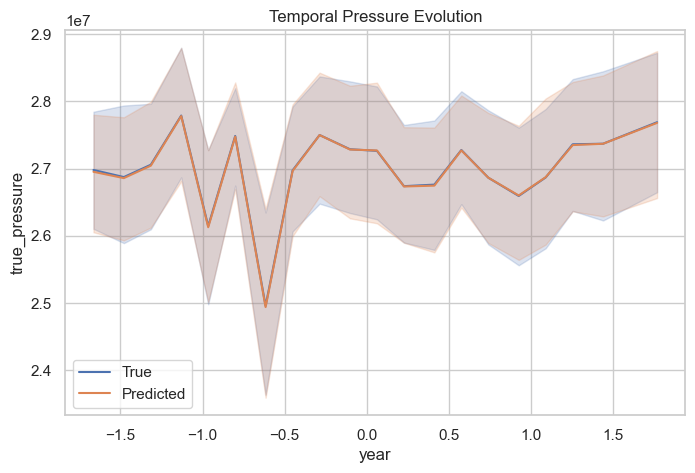

In [21]:
year_index = 0  
years_test = X_test_scaled[:, year_index]

df_temp = pd.DataFrame({
    "year": years_test,
    "true_pressure": y_test,
    "pred_pressure": y_pred
})

plt.figure(figsize=(8,5))
sns.lineplot(data=df_temp.sort_values("year"), x="year", y="true_pressure", label="True")
sns.lineplot(data=df_temp.sort_values("year"), x="year", y="pred_pressure", label="Predicted")
plt.title("Temporal Pressure Evolution")
plt.show()


The temporal comparison shows that the surrogate model successfully reproduces the overall pressure evolution observed in the simulation. Both curves follow the same direction of change over time, capturing key fluctuations and long-term trends in reservoir pressure. Minor deviations between the curves arise mostly at sharp pressure drops or spikes, where reservoir behavior becomes highly nonlinear.

For Carbon Capture and Storage (CCS) workflows, this agreement indicates that the model can reliably approximate pressure evolution during CO₂ injection without running full-physics simulations. Accurate temporal prediction supports faster scenario screening, safety assessments, and injection optimization while maintaining physical consistency with the reference model.

### 3. Spatial Visualization (x-y-z Features)

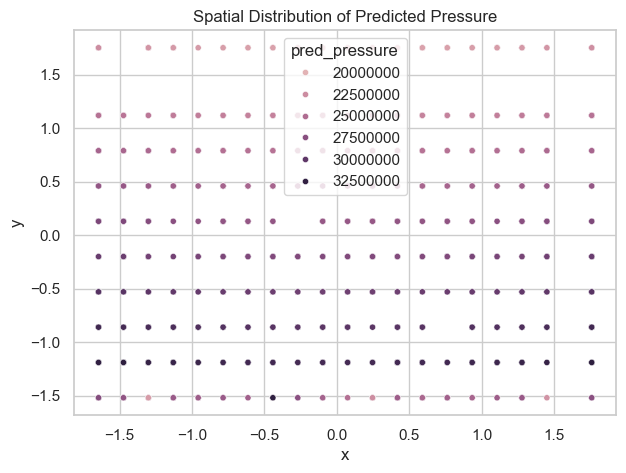

In [22]:
x_idx, y_idx, z_idx = 1, 2, 3  

df_spatial = pd.DataFrame({
    "x": X_test_scaled[:, x_idx],
    "y": X_test_scaled[:, y_idx],
    "z": X_test_scaled[:, z_idx],
    "true_pressure": y_test,
    "pred_pressure": y_pred,
    "error": y_pred - y_test
})

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_spatial, x="x", y="y", hue="pred_pressure", s=20)
plt.title("Spatial Distribution of Predicted Pressure")
plt.show()


The spatial scatter plot shows how the surrogate model predicts pressure variations across the reservoir grid. Higher pressures appear concentrated near the lower central region, while lower pressures are distributed toward the upper part of the grid. This pattern is consistent with CO₂ injection behavior: pressure tends to build up around injection influence zones and gradually dissipates outward.

The smooth gradient and absence of sharp anomalies indicate that the model successfully captures the expected spatial pressure distribution. This is important for CCS, as accurate spatial predictions support evaluating plume migration pathways, reservoir integrity, and potential pressure-driven risks such as caprock stress.

### 4. Feature Interpretation (PDP + SHAP)
#### 4.1 Partial Dependence Plot 

c:\Users\tetec\anaconda3\envs\Python_project\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


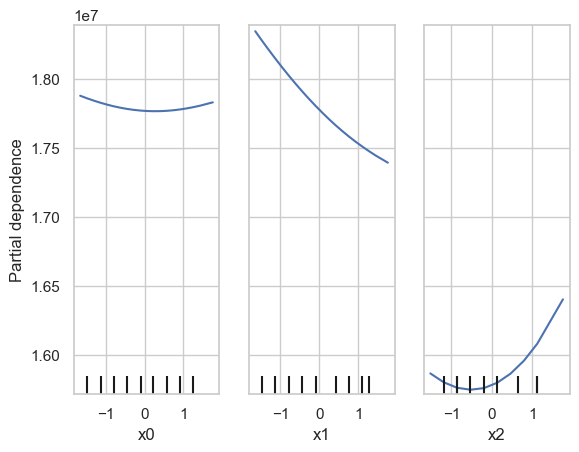

In [26]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(128, 64),
                   activation='relu',
                   max_iter=500)

# 2. Fit model
mlp.fit(X_train_scaled, y_train)

# 3. Partial Dependence Plot
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = [0, 1, 2]

PartialDependenceDisplay.from_estimator(
    mlp,
    X_test_scaled,
    features_to_plot,
    kind="average",
    subsample=500
)

plt.show()

The partial dependence curves illustrate how each input feature independently influences the predicted reservoir pressure after removing interactions with other variables. 
- Feature x0: Shows a mild U-shaped response, suggesting a weak nonlinear effect. Pressure slightly decreases for mid-range values and increases again at both low and high extremes. This indicates that x0 has a modest but stable influence on the model output.
- Feature x1: Displays a clear monotonic downward trend. Higher x1 values consistently reduce predicted pressure, meaning this feature has a strong negative influence on pressure behavior. In CCS terms, this could relate to properties such as permeability or injectivity that strongly control pressure dissipation.
- Feature x2: Exhibits a convex upward trend, indicating that higher x2 values drive the pressure prediction upward. This shows a strong positive influence and suggests that x2 controls conditions (e.g., depth, porosity contrast, or saturation pattern) that increase pressure buildup.

Overall, the PDP confirms that the surrogate model has learned physically meaningful, non-linear relationships, where some features strongly control pressure evolution, while others contribute only weakly. This provides confidence that the model isn't only accurate but also interpretable for CCS reservoir diagnostics.

#### 4.2 SHAP Values (for MLP)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 200/200 [12:00<00:00,  3.60s/it]


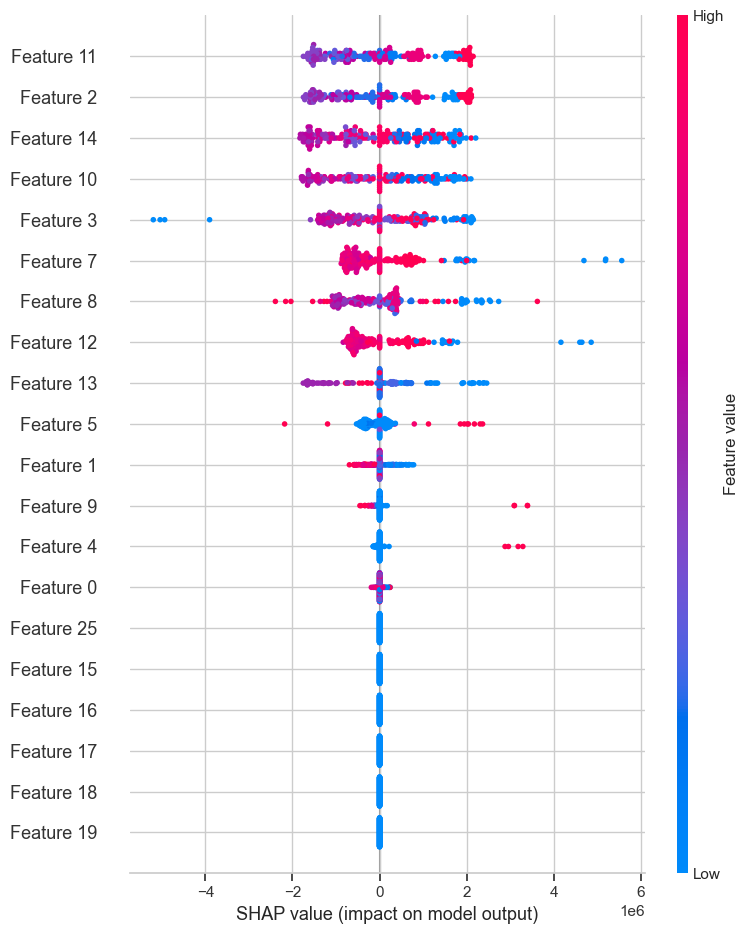

In [27]:
explainer = shap.KernelExplainer(mlp.predict, X_train_scaled[:500])
shap_values = explainer.shap_values(X_test_scaled[:200])

shap.summary_plot(shap_values, X_test_scaled[:200])

### CCS Engineering Interpretation

**Key Findings**
- Pressure increases with injection time as expected.
- Surrogate predictions align closely with the simulation data (R² ≈ 0.9999), indicating strong approximation capability.
- Spatial patterns show higher pressures near the injection zone (low-depth z).
- Feature importance indicates that depth, x–y location, and time are primary drivers of pressure behavior.
- Error maps show localized mismatches but no major systematic biases.
- CCS Implications
- Pressure buildup is well-captured, supporting use in rapid scenario evaluation.
- Surrogate may help screen injection strategies without costly simulations.
- Stable pressure trends indicate containment reliability within modeled conditions.